In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import CameraNetwork
import traceback
import time
import os

results_path = os.path.abspath('results')
plt.rc('axes', color_cycle=['r', 'g', 'b'])

import winsound
def playsound(frequency,duration):
    winsound.Beep(frequency,duration)

### Start The Camera client

In [3]:
c = CameraNetwork.CLIclient()
proxy_params = CameraNetwork.retrieve_proxy_parameters()
c.start(proxy_params)
time.sleep(3)
SERVERS = c.client_instance.servers
#if 'pi' in SERVERS:
#    SERVERS.remove('pi')
print SERVERS

yay, got new server mvMLC200!
Adding the new server
['mvMLC200']


# All Code

In [4]:
def RGBdict(arr):
    
    return dict(zip(('Red', 'Green', 'Blue'), arr))

def stats_per_channel(img, as_dict=True):
    
    if len(img.shape) == 3:
        return [img.mean()], [img.std()]
    
    means = []
    stds = []
    stds_per_pixel = []
    snrs = []
    for ch in range(3):
        means.append(img[...,ch].mean())
        stds.append(img[...,ch].std())
        stds_per_pixel.append(img[...,ch].std(axis=0).mean())
        snr = 20*np.log10(img[...,ch].mean(axis=0)/img[...,ch].std(axis=0))
        snrs.append(snr[snr!=np.inf].mean())
    if as_dict:
        return RGBdict(means), RGBdict(stds), RGBdict(stds_per_pixel), RGBdict(snrs)
    else:
        return means, stds, stds_per_pixel, snrs
    
    
def measureCameraStats(servers, base_name, repeats=20, exposures=range(1000, 20000, 1000)):
    fig, axes = plt.subplots(4, len(servers), figsize=(18, 12), sharex=True, sharey='row')

    for server_ind, server in enumerate(servers):
        means = []
        stds = []
        stds_pixel = []
        snrs = []
        for exposure in exposures:
            arrays = []
            for i in range(repeats):
                try:
                    arrays.append(c.get_array(server, exposure_us=exposure, gain_db=100 if server=='pi' else 0)[0])
                except:
                    pass
            arrays = np.array(arrays)

            mean, std, std_pixel, snr = stats_per_channel(arrays, as_dict=False)
            
            means.append(mean)
            stds.append(std)
            stds_pixel.append(std_pixel)
            snrs.append(snr)

        stds = np.array(stds)
        means = np.array(means)
        stds_pixel = np.array(stds_pixel)
        snrs = np.array(snrs)
        
        np.save(os.path.join(results_path, 'means_{server}_{base_name}.npy'.format(base_name=base_name, server=server)), means)
        np.save(os.path.join(results_path, 'stds_{server}_{base_name}.npy'.format(base_name=base_name, server=server)), stds)
        np.save(os.path.join(results_path, 'stds_pixel_{server}_{base_name}.npy'.format(base_name=base_name, server=server)), stds_pixel)
        np.save(os.path.join(results_path, 'snrs_{server}_{base_name}.npy'.format(base_name=base_name, server=server)), snrs)
        
        axes[0][server_ind].plot(exposures, means, linewidth=3.0)
        axes[0][server_ind].set_title(server)
        axes[1][server_ind].plot(exposures, stds, linewidth=3.0)
        axes[2][server_ind].plot(exposures, stds_pixel, linewidth=3.0)
        axes[3][server_ind].plot(exposures, snrs, linewidth=3.0)

    axes[0][0].set_ylabel('Means')
    axes[1][0].set_ylabel('STD')
    axes[2][0].set_ylabel('STD_PIXEL')
    axes[3][0].set_ylabel('SNR')


def measureServer(server, base_name, repeats=10, exposures=range(1000, 20000, 1000)):
    arrays = []
    for exposure in exposures:
        array = c.get_array(server, exposure_us=exposure, gain_db=100 if server=='pi' else 0, frames_num=repeats)[0]

        np.save(
            os.path.join(
                results_path,
                'arrays_{server}_{base_name}_{exposure}.npy'.format(
                    base_name=base_name,
                    server=server,
                    exposure=exposure
                )
            ),
            array
        )
        print array.shape
        arrays.append(array)
    
    return arrays


def plotServer(arrays_red, arrays_green, arrays_blue, exposures):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey='row')

    for color_ind, (arrays, color) in enumerate(zip((arrays_red, arrays_green, arrays_blue), ('red', 'green', 'blue'))):
        means = [array.mean(axis=3) for array in arrays]
        stds = [array.std(axis=3) for array in arrays]
        snrs = [20*np.log10(mean/std) for mean, std in zip(means, stds)]
        for i in range(len(snrs)):
            snrs[i][snrs[i]==np.inf] = np.nan
        snrs = [np.nanmean(np.nanmean(snr, axis=0), axis=0) for snr in snrs]
        means = [np.mean(np.mean(mean, axis=0), axis=0) for mean in means]
        
        axes[0][color_ind].plot(exposures, means, linewidth=3.0)
        axes[0][color_ind].set_title(color)
        axes[1][color_ind].plot(exposures, snrs, linewidth=3.0)

    axes[0][0].set_ylabel('Means')
    axes[1][0].set_ylabel('SNR')

    
def square_mean(arrays):
    """Join-mean 4 pixels (2x2)"""
    
    array_square = []
    for array in arrays:
        a1 = array[::2, ::2, ...].astype(np.float)
        a2 = array[::2, 1::2, ...].astype(np.float)
        a3 = array[1::2, ::2, ...].astype(np.float)
        a4 = array[1::2, 1::2, ...].astype(np.float)
    
        array_square.append((a1+a2+a3+a4)/4)
    
    return np.array(array_square).astype(np.uint8)

# Dark Noise

In [52]:
means = []
stds = []
stds_pixel = []
REPEATS = 30

for server in SERVERS:
    arrays = []
    for i in range(REPEATS):
        try:
            array = c.get_array(server, exposure_us=10000, gain_db=100 if server=='pi' else 0)
            arrays.append(array)
        except Exception:
            print 'bad frame from server {server}'.format(server=server)
            print traceback.format_exc()

        playsound(5000, 100)

    arrays = np.array(arrays)
    mean, std, std_pixel, snrs = stats_per_channel(arrays)
    
    means.append(mean)
    stds.append(std)
    stds_pixel.append(std_pixel)
    playsound(1000, 500)

## Dark-Noise Results

### Means

In [54]:
means_df = pd.DataFrame(means, index=SERVERS)
means_df.save(os.path.join(results_path, 'means.df'))
means_df

,Blue,Green,Red
UI122xLE,2.304286,1.459336,2.799591
pi,0.000019,4.631161,0.256773
mvMLC200wC,7.247132,7.036939,7.253937
mvMLC202dC,0.001232,0.001061,0.001263
UI125xMLC,0.000126,0.000002,0.000005


### STD

In [55]:
std_df = pd.DataFrame(stds, index=SERVERS)
std_df.save(os.path.join(results_path, 'std.df'))
std_df

,Blue,Green,Red
UI122xLE,1.124523,0.549086,0.907368
pi,0.011203,4.449668,1.366077
mvMLC200wC,0.627168,0.514614,0.639337
mvMLC202dC,0.462555,0.327407,0.467836
UI125xMLC,0.061890,0.001467,0.002500


### STD by Pixel

In [56]:
std_pixel_df = pd.DataFrame(stds_pixel, index=SERVERS)
std_pixel_df.save(os.path.join(results_path, 'std_pixel.df'))
std_pixel_df

,Blue,Green,Red
UI122xLE,0.811461,0.393576,0.573804
pi,0.000044,1.772610,1.005477
mvMLC200wC,0.431259,0.361675,0.431552
mvMLC202dC,0.001375,0.000511,0.001468
UI125xMLC,0.000005,0.000003,0.000005


# Measure Exposures

## Red Channel

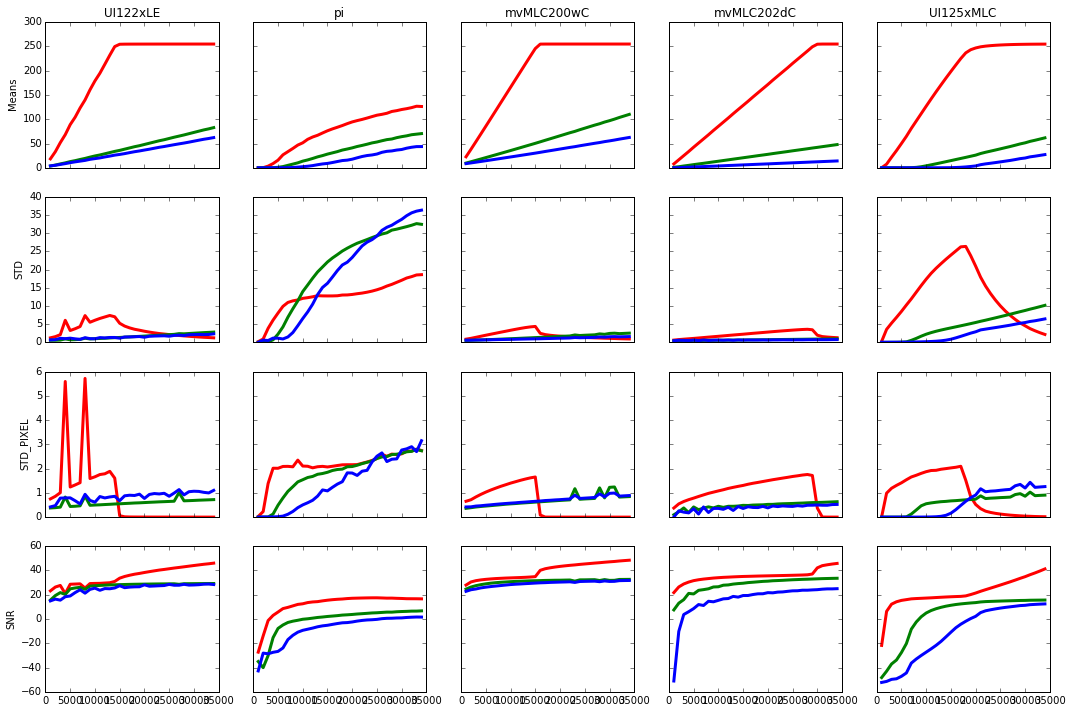

In [68]:
measureCameraStats(SERVERS, base_name='red', repeats=10, exposures=range(1000, 35000, 1000))

## Green Channel

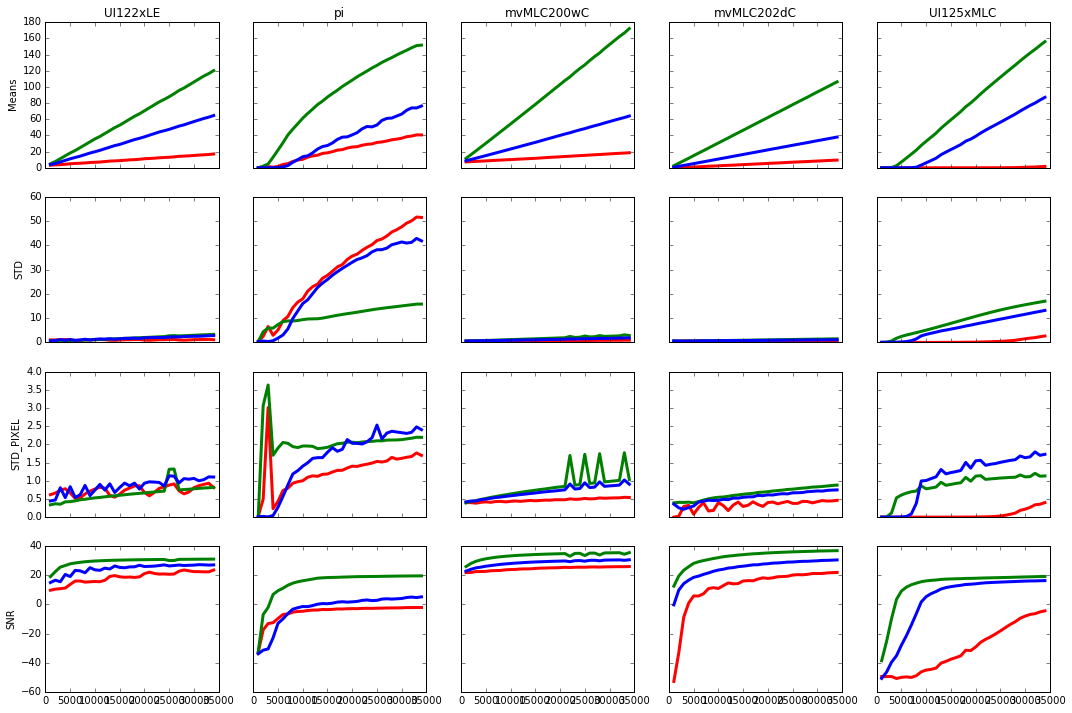

In [69]:
measureCameraStats(SERVERS, base_name='green', repeats=10, exposures=range(1000, 35000, 1000))

## Blue Channel

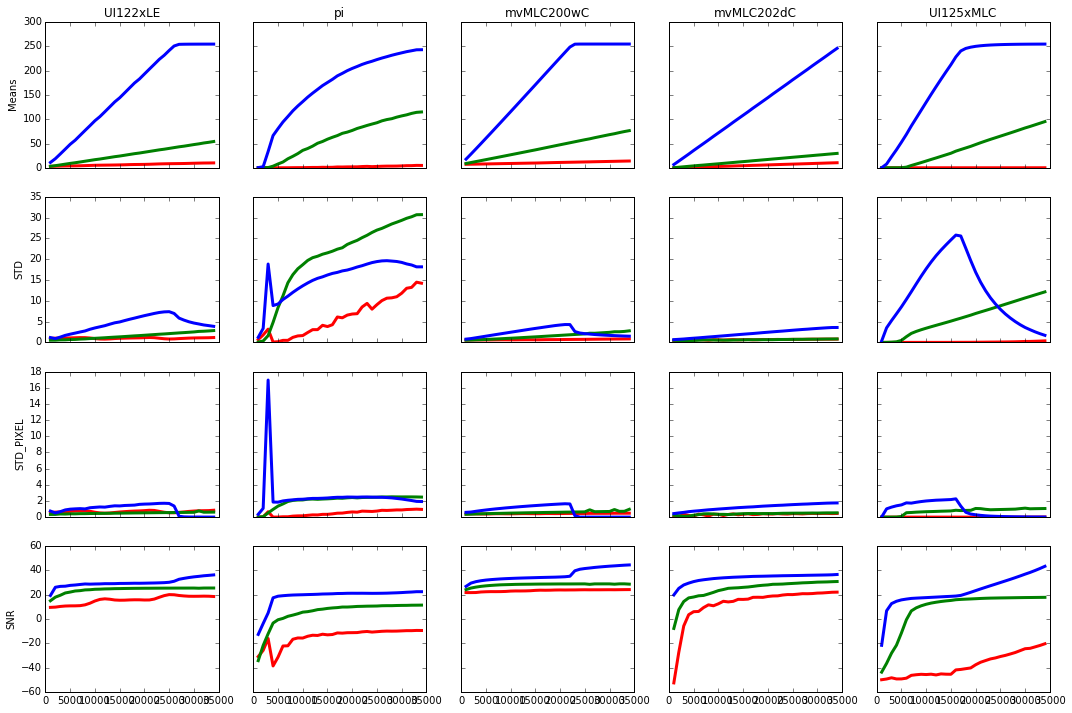

In [70]:
measureCameraStats(SERVERS, base_name='blue', repeats=10, exposures=range(1000, 35000, 1000))

## Dark Noise

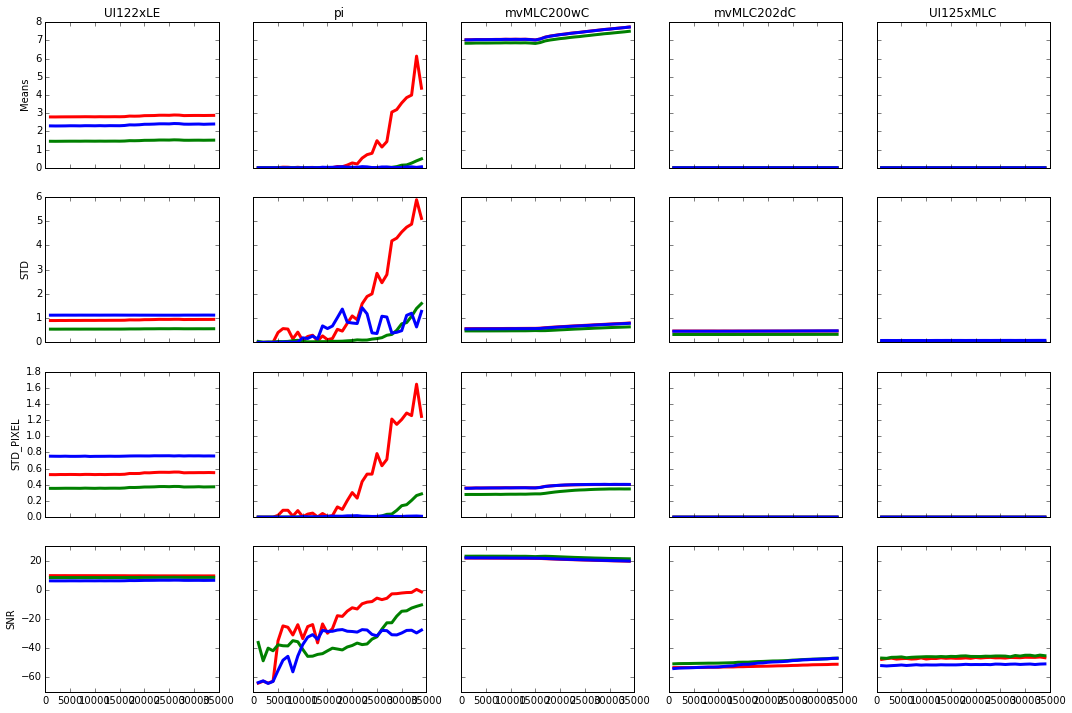

In [71]:
measureCameraStats(SERVERS, base_name='DN', repeats=10, exposures=range(1000, 35000, 1000))

## Updated RPi Graphs

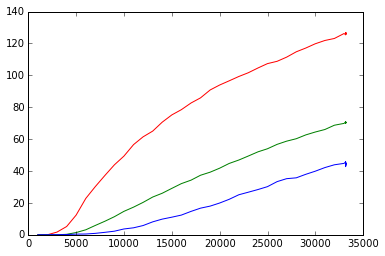

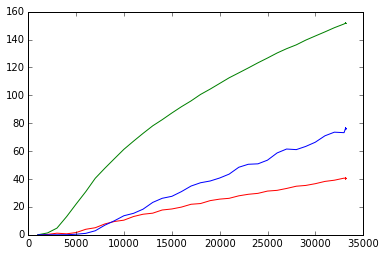

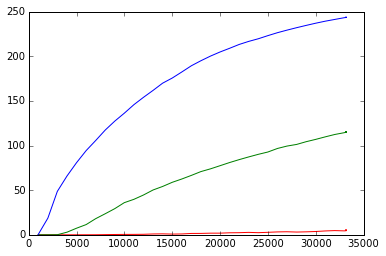

In [10]:
exposures = np.arange(1000, 70000, 1000)
colors = ['red', 'green', 'blue']

for color in colors:
    data = np.load(os.path.join(results_path, 'means_{server}_{color}.npy'.format(server='pi', color=color)))
    plt.figure()
    plt.plot(real_exposures, data)

# Load All Data

In [51]:
exposures = np.arange(1000, 35000, 1000)
servers = [['pi', ['UI122xLE', 14], ['UI125xMLC', 14], ['mvMLC200wC', 14], ['mvMLC202dC', 14], ]
colors = ['red', 'green', 'blue']

mat = []
for server, max_ind in servers:
    for color in colors:
        data = np.load(os.path.join(results_path, 'means_{server}_{color}.npy'.format(server=server, color=color)))
        p_red = np.polyfit(exposures[:max_ind], data[:max_ind, 0], 1)
        p_green = np.polyfit(exposures[:max_ind], data[:max_ind, 1], 1)
        p_blue = np.polyfit(exposures[:max_ind], data[:max_ind, 2], 1)
        mat.append([p_red[0], p_green[0], p_blue[0]])

    print np.linalg.cond(mat)


SyntaxError: invalid syntax (<ipython-input-51-62eaaf52b505>, line 3)

## Analyzing the Data

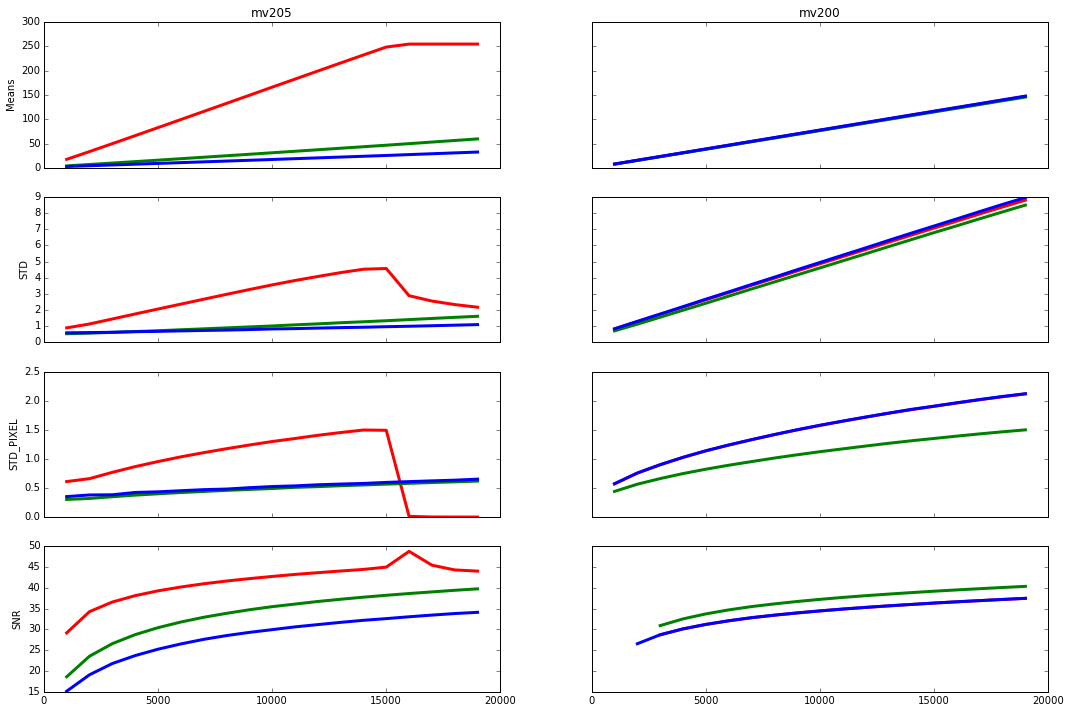

In [17]:
measureCameraStats(SERVERS, base_name='red', repeats=5, exposures=range(1000, 20000, 1000))

In [19]:
arrays = measureServer('mv200', 'red', repeats=10, exposures=range(1000, 16000, 500))

(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)


In [58]:
means = [array.mean(axis=3) for array in arrays]
stds = [array.std(axis=3) for array in arrays]
snrs = [20*np.log10(mean/std) for mean, std in zip(means, stds)]
for i in range(len(snrs)):
    snrs[i][snrs[i]==np.inf] = np.nan
snrs = [np.nanmean(np.nanmean(snr, axis=0), axis=0) for snr in snrs]

C:\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [59]:
snrs

[array([ 31.06273678,  27.57746445,  26.29037537]),
 array([ 33.86434133,  28.84494014,  26.80735332]),
 array([ 34.99447888,  29.78546265,  27.20561041]),
 array([ 35.93372809,  30.56934661,  27.78993449]),
 array([ 36.67101244,  31.27988   ,  28.4274398 ]),
 array([ 37.29973351,  31.86324957,  28.7862393 ]),
 array([ 37.86620316,  32.44480751,  29.05300523]),
 array([ 38.36857074,  32.95323557,  29.38242349]),
 array([ 38.83843709,  33.44937934,  29.78073614]),
 array([ 39.24688717,  33.86188096,  30.15994505]),
 array([ 39.6305026 ,  34.27626568,  30.38125914]),
 array([ 39.98853253,  34.63950687,  30.58896612]),
 array([ 40.30094217,  35.00615956,  30.83297847]),
 array([ 40.61153988,  35.33191471,  31.12449329]),
 array([ 40.89763176,  35.64747158,  31.39796834]),
 array([ 41.16726686,  35.90563066,  31.59896052]),
 array([ 41.44206507,  36.16401124,  31.82078011]),
 array([ 41.67344903,  36.43791282,  32.0110185 ]),
 array([ 41.92415656,  36.69497281,  32.2077365 ]),
 array([ 42.

In [49]:
arrays5 = measureServer('mv205', 'red', repeats=10, exposures=range(1000, 35000, 1000))

(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)
(972L, 1296L, 3L, 10L)


In [66]:
arrays6 = [square_mean(a) for a in arrays5]

In [67]:
means6 = [array.mean(axis=3) for array in arrays6]
stds6 = [array.std(axis=3) for array in arrays6]
snrs6 = [20*np.log10(mean/std) for mean, std in zip(means6, stds6)]
for i in range(len(snrs6)):
    snrs6[i][snrs6[i]==np.inf] = np.nan
snrs6 = [np.nanmean(np.nanmean(snr, axis=0), axis=0) for snr in snrs6]

## Low Resolution

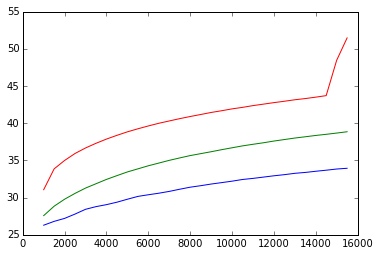

In [72]:
plt.plot(exposures, snrs)

## High Resolution

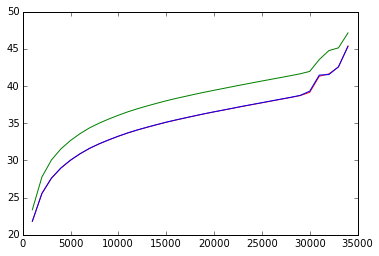

In [70]:
plt.plot(exposures5, snrs5)

## Binned High Resolution

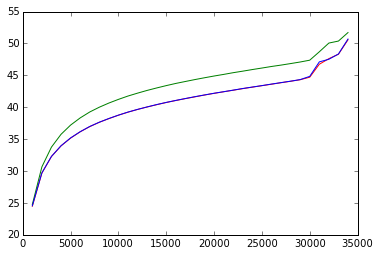

In [71]:
plt.plot(exposures5, snrs6)

# IDS UI-1550LE

Colibri set to 10% for each channel (separately)

In [39]:
exposures = range(1000, 100000, 10000)
arrays_red = measureServer('ids', 'red', repeats=10, exposures=exposures)

(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)


In [42]:
arrays_green = measureServer('ids', 'green', repeats=10, exposures=exposures)

(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)


In [43]:
arrays_blue = measureServer('ids', 'blue', repeats=10, exposures=exposures)

(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)


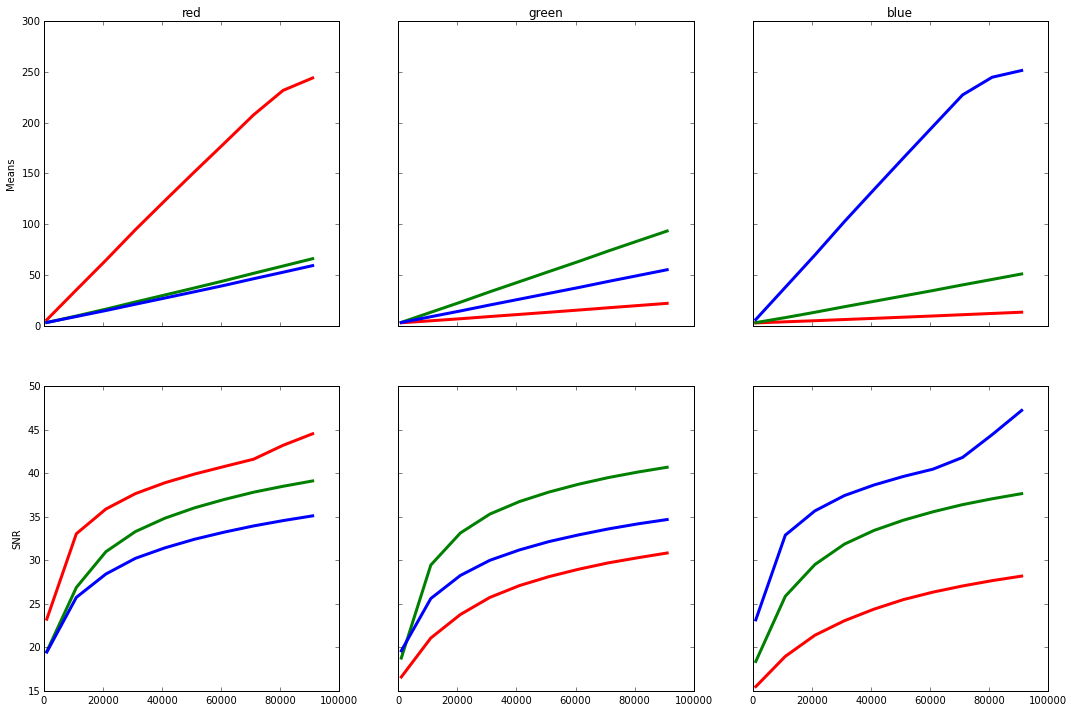

In [59]:
plotServer(arrays_red, arrays_green, arrays_blue, exposures)

### Aggregate Neighbour Pixels (2x2)

Colibri set to 10% for red/blue channels and 20% for green

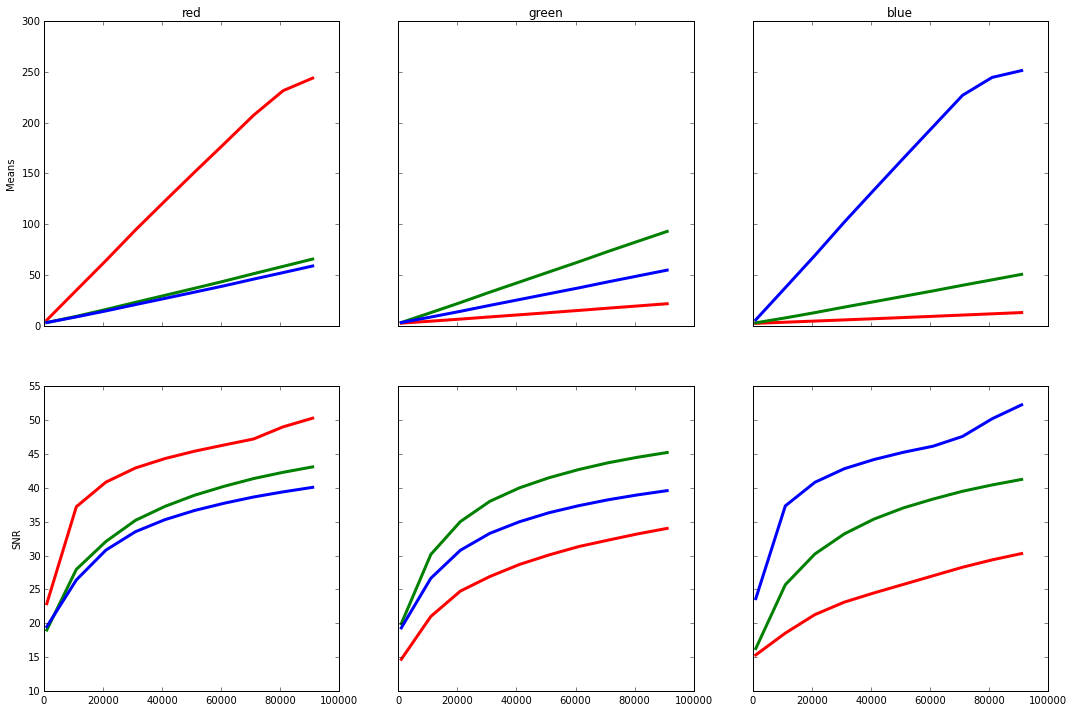

In [63]:
arrays_red_sq, arrays_green_sq, arrays_blue_sq = [square_mean(arrays) for arrays in (arrays_red, arrays_green, arrays_blue)]
plotServer(arrays_red_sq, arrays_green_sq, arrays_blue_sq, exposures)

### Compare UI-1551LE to mvMLC200

In [12]:
exposures_mv = range(100, 30000, 3000)
exposures_ids = range(100, 100000, 10000)

arrays_red_mv = measureServer('mvMLC200', 'red', repeats=10, exposures=exposures_mv)
arrays_red_ids = measureServer('UI-1551LE', 'red', repeats=10, exposures=exposures_ids)

(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)


In [13]:
arrays_green_mv = measureServer('mvMLC200', 'green', repeats=10, exposures=exposures_mv)
arrays_green_ids = measureServer('UI-1551LE', 'green', repeats=10, exposures=exposures_ids)

(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)


In [14]:
arrays_blue_mv = measureServer('mvMLC200', 'blue', repeats=10, exposures=exposures_mv)
arrays_blue_ids = measureServer('UI-1551LE', 'blue', repeats=10, exposures=exposures_ids)

(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(240L, 376L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)
(600L, 800L, 3L, 10L)


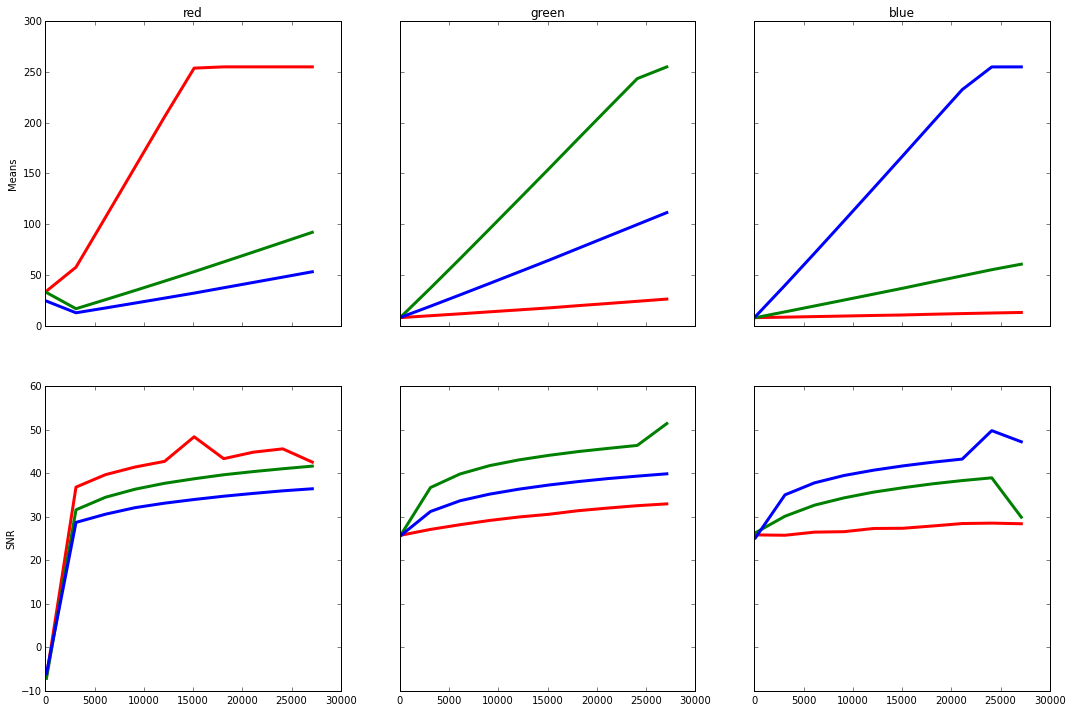

In [15]:
plotServer(arrays_red_mv, arrays_green_mv, arrays_blue_mv, exposures_mv)

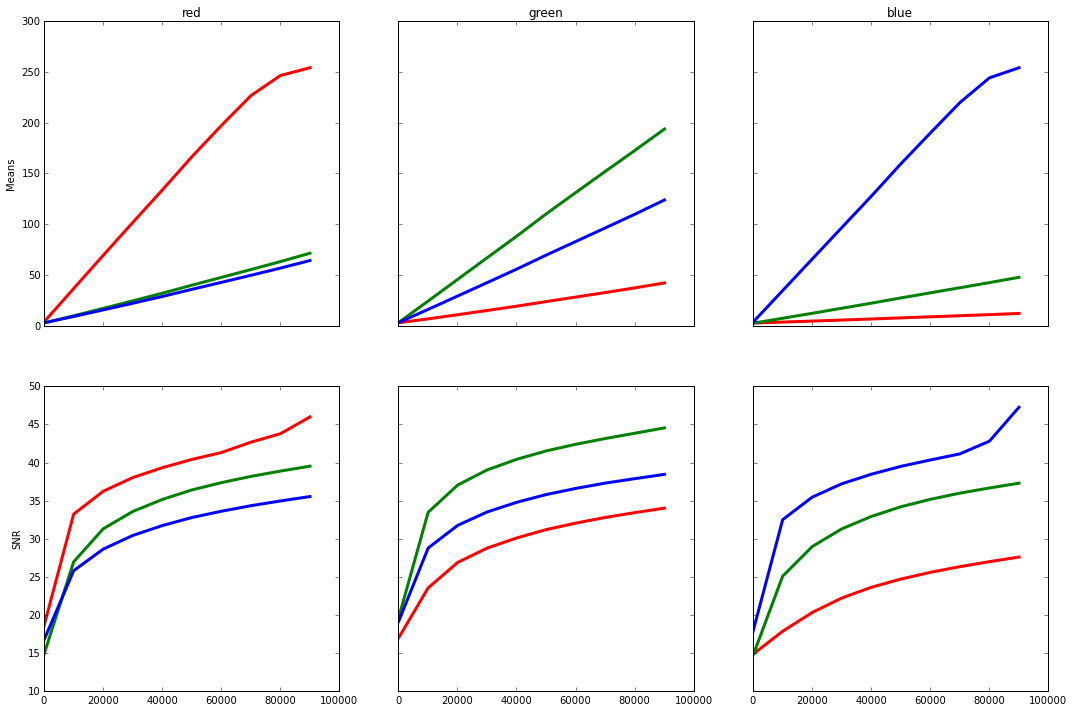

In [16]:
plotServer(arrays_red_ids, arrays_green_ids, arrays_blue_ids, exposures_ids)

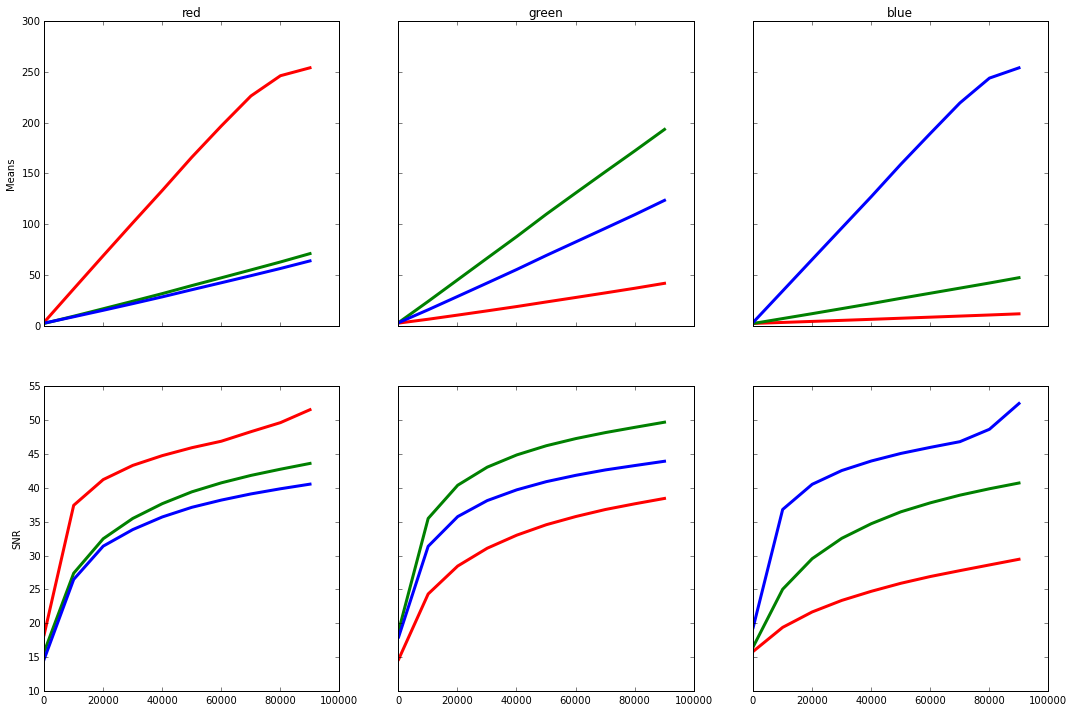

In [17]:
arrays_red_ids_sq, arrays_green_ids_sq, arrays_blue_ids_sq = [square_mean(arrays) for arrays in (arrays_red_ids, arrays_green_ids, arrays_blue_ids)]
plotServer(arrays_red_ids_sq, arrays_green_ids_sq, arrays_blue_ids_sq, exposures_ids)

# Utils

In [21]:
%qtconsole